##Shape Recognition

###Google Doodle Dataset

In [100]:
!wget 'https://raw.githubusercontent.com/thejediboySHASHANK/Google-Doodle-Classes/main/mini_classes.txt'

--2024-08-10 11:41:03--  https://raw.githubusercontent.com/thejediboySHASHANK/Google-Doodle-Classes/main/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66 [text/plain]
Saving to: ‘mini_classes.txt.1’

mini_classes.txt.1  100%[===================>]      66  --.-KB/s    in 0s      

2024-08-10 11:41:03 (1.46 MB/s) - ‘mini_classes.txt.1’ saved [66/66]



Read the classes name

In [101]:
f = open("mini_classes.txt", "r")
#And for the purpose of reading
classes = f.readlines()
f.close()

In [102]:
classes = [c.replace('\n', '').replace(' ', '_') for c in classes]

###Downloading the Dataset

Looping over the classes and downloading the correspondent data

In [103]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [104]:
import urllib.request
def download():
    base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in classes:
        formatted_class = c.replace('_', '%20')
        url = base_url + formatted_class + '.npy'
        destination_path = f'data/{c}.npy'
        print(f"Attempting to download from: {url}")  # Debugging output
        try:
            urllib.request.urlretrieve(url, destination_path)
            print(f"Successfully downloaded {c}.npy")
        except Exception as e:
            print(f"Failed to download {c}.npy: {e}")

In [105]:
download()

Attempting to download from: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/circle.npy
Successfully downloaded circle.npy
Attempting to download from: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hexagon.npy
Successfully downloaded hexagon.npy
Attempting to download from: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/line.npy
Successfully downloaded line.npy
Attempting to download from: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/octagon.npy
Successfully downloaded octagon.npy
Attempting to download from: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/square.npy
Successfully downloaded square.npy
Attempting to download from: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy
Successfully downloaded star.npy
Attempting to download from: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/triangle.npy
Successfully downloaded triangle.npy
Attemp

###Importing the libraries

In [106]:
import os
import glob
import numpy as np
from tensorflow.python.keras import layers
from tensorflow import keras
import tensorflow as tf

print(len(os.listdir('data')))

8


Version check

In [107]:
#Version
print("Keras ", keras.__version__)
print("Numpy ", np.__version__)
print("Tensorflow ", tf.__version__)

Keras  3.4.1
Numpy  1.26.4
Tensorflow  2.17.0


###Loading the Data

Each class contains different number of samples of arrays stored in .npy format.

In [108]:
def load_data(root, vfold_ratio=0.2, max_items_per_class=10000):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [109]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [110]:
print(len(x_train))

64000


Show some random data

circle


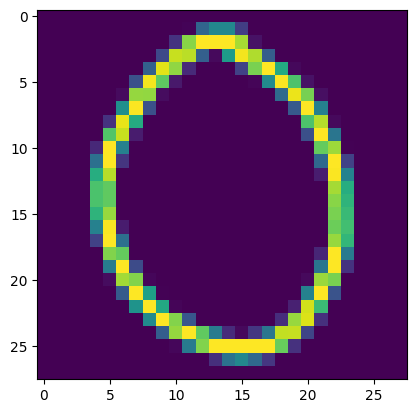

In [111]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

###Preprocessing The Data

In [112]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

###Defining the Model

In [113]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))  # Change 100 to 8 if there are only 8 classes

# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,184 (383.53 KB)

 Trainable params: 98,184 (383.53 KB)

 Non-trainable params: 0 (0.00 B)

None


###Training the Model

In [114]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
225/225 - 41s - 182ms/step - loss: 0.7173 - top_k_categorical_accuracy: 0.9779 - val_loss: 0.4837 - val_top_k_categorical_accuracy: 0.9892
Epoch 2/5
225/225 - 40s - 178ms/step - loss: 0.4241 - top_k_categorical_accuracy: 0.9904 - val_loss: 0.3899 - val_top_k_categorical_accuracy: 0.9914
Epoch 3/5
225/225 - 41s - 180ms/step - loss: 0.3681 - top_k_categorical_accuracy: 0.9915 - val_loss: 0.3674 - val_top_k_categorical_accuracy: 0.9922
Epoch 4/5
225/225 - 41s - 183ms/step - loss: 0.3440 - top_k_categorical_accuracy: 0.9925 - val_loss: 0.3536 - val_top_k_categorical_accuracy: 0.9925
Epoch 5/5
225/225 - 41s - 184ms/step - loss: 0.3284 - top_k_categorical_accuracy: 0.9928 - val_loss: 0.3338 - val_top_k_categorical_accuracy: 0.9922


###Testing the Accuracy

In [115]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 99.23%


###Inference

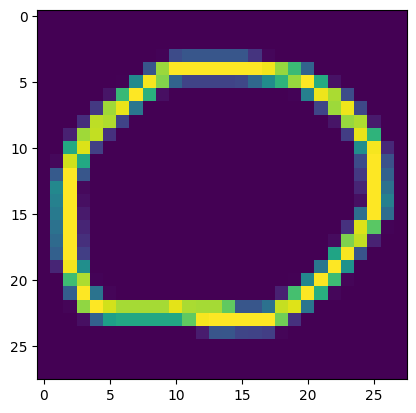

In [122]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
# print(img)
# img = 'pic3.png'
plt.imshow(img.squeeze())

In [123]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
['circle', 'octagon', 'hexagon', 'suitcase', 'line']


For Manual or Custom Image Inference

<ipython-input-126-badb12612a0b>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((image_size, image_size), Image.ANTIALIAS)


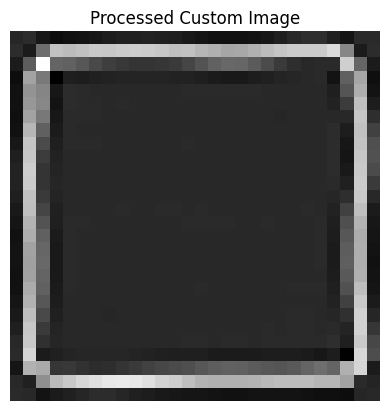

In [126]:
from PIL import Image
import numpy as np

def prepare_custom_image(image_path, image_size=28):
    # Load the image
    img = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize image
    img = img.resize((image_size, image_size), Image.ANTIALIAS)

    # Convert to numpy array and normalize
    img_array = np.array(img, dtype=np.float32) / 255.0

    # Invert the image to match training data style
    img_array = 1 - img_array  # Subtract from 1 to invert the grayscale values

    # Reshape the array to fit the model input
    img_array = img_array.reshape(1, image_size, image_size, 1)

    return img_array

# Path to your custom image
image_path = 'sq.png'

# Prepare the image
custom_img = prepare_custom_image(image_path)
import matplotlib.pyplot as plt

# Plot the processed custom image to verify inversion
plt.imshow(custom_img.reshape(28, 28), cmap='gray')
plt.title("Processed Custom Image")
plt.axis('off')
plt.show()


Predicting the Custom Image shape

In [127]:
# Corrected prediction call
pred = model.predict(custom_img)[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
['square', 'suitcase', 'line', 'hexagon', 'octagon']


###Store the Classes

In [128]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

###Installing TensorFlowJS

In [ ]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 758.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 53.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: ml-dtypes
    Found existing installation: ml

###Save and Convert the Model

In [129]:
model.save('keras.h5')

In [ ]:
!mkdir model
# !tensorflowjs_converter --input_format keras keras.h5 model/

###Zip and Download

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/class_names.txt (deflated 10%)


In [ ]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>